# Code for creating projected mass maps from simulations

Code written by Sebastian Bocquet, and adapet by Alessandra Fumagalli

In [79]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import time

plt.rcParams['xtick.labelsize'] = 13.
plt.rcParams['ytick.labelsize'] = 13.
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top']       = True
plt.rcParams['ytick.right']     = True

%matplotlib inline

# Cosmologies and snapshots for Magneticum simulations

The code has been developed to work on **Magneticum** simulations: http://www.magneticum.org/simulations.html <br>
The example reported here refers to simulations labelled **Box1a**.


N.B. Magneticum simulations have no special features for producing mass maps. The code can be adapted to run on different sets of simulations. It just takes some extra work to adapt it to read them.


In [2]:
# define cosmologies
cosmologies = {}
cosmologies['C1']  = '0.153_0.0408_0.614_0.666'
cosmologies['C2']  = '0.189_0.0455_0.697_0.703'
cosmologies['C3']  = '0.200_0.0415_0.850_0.730'
cosmologies['C4']  = '0.204_0.0437_0.739_0.689'
cosmologies['C5']  = '0.222_0.0421_0.793_0.676'
cosmologies['C6']  = '0.232_0.0413_0.687_0.670'
cosmologies['C7']  = '0.268_0.0449_0.721_0.699'
cosmologies['C8']  = '0.272_0.0456_0.809_0.704'
cosmologies['C9']  = '0.301_0.0460_0.824_0.707'
cosmologies['C10'] = '0.304_0.0504_0.886_0.740'
cosmologies['C11'] = '0.342_0.0462_0.834_0.708'
cosmologies['C12'] = '0.363_0.0490_0.884_0.729'
cosmologies['C13'] = '0.400_0.0485_0.650_0.675'
cosmologies['C14'] = '0.406_0.0466_0.867_0.712'
cosmologies['C15'] = '0.428_0.0492_0.830_0.732'

# snapshot redshifts
redshifts = [0., 0.137, 0.293, 0.407, 0.672, 0.901, 1.179, 1.478, 1.980, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan][::-1]

# Create mass maps - files

This code creates the mass map for each halo in the snapshot. <br>
First, the code matches halos between the DM and HYDRO catalogs and adds a flag "has_profile" to each halo. <br>
Mass maps will be created only for halos with *has_profile=1*. <br>
To create the maps, the code projects the particle positions around each halo into a cylinder of half-length *l_proj* and radius *r_max*.<br> 
For each halo, it creates three projections, along the three axes.

To create maps you need:

- **Magneticum_maps_KDTree_all.py** is the code that matches catalogs, assigns the profile flag, and creates maps
- **config.yaml** is the config file defining the code settings (e.g., cosmology, snapshot number, simulation type, ...)
- **get_maps_magneticum.py** is the code that reads the input setting and run the mass map code for that specific configuration
- **run_get_maps_magneticum.sh** to submit the job on one node (with mpi), since the map creation is computationally expensive



# Output catalog

The output file is a hdf5 file that contains all the info (both DM and HYDRO) of the matched catalogs, and the mass maps that have been created.

In [42]:
### Set parameters for running the mass map code

# snapshot number
snap_num   = 12

# hydro or dm
sim_type   = 'hydro'   

# select cosmology from C1 to C14
cosmo_name = 'C10'   
cosmo      = cosmologies[cosmo_name]    

# output file
cat_file = "halo_catalog_%s_snap%02d.h5py" %(cosmo,snap_num)
file     = h5py.File(cat_file, 'r')

In [43]:
# info stored in the file
print(file.keys())

<KeysViewHDF5 ['BoxSize', 'data_path', 'halos', 'l_proj', 'redshift', 'resolution [kpc', 'scale_fac']>


In [44]:
# Each halo is saved separately
print(file['halos'].keys())

<KeysViewHDF5 ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111',

In [45]:
# Each halo contains info about hydro and DM mass, radius, etc..
# The halos with has_profile=1 have the mass profile ("dm_Sigma" and/or "hydro_Sigma")
# The file in the example only contains the HYDRO profile (simply because the DM one was not created)
print('has_profile: ', file['halos/0/has_profile'][()])
print(file['halos/0'].keys())


has_profile:  1
<KeysViewHDF5 ['GPOS', 'M200c', 'M200m', 'M500c', 'M500m', 'Mvir', 'Rvir', 'good_match', 'has_profile', 'hydro_GPOS', 'hydro_M200c', 'hydro_M200m', 'hydro_M500c', 'hydro_M500m', 'hydro_Rvir', 'hydro_Sigma', 'hydro_name', 'match_dist']>


In [54]:
# for halos with has_profile=0, there is no Sigma profile 
print('has_profile: ', file['halos/64/has_profile'][()])
print(file['halos/67'].keys())


has_profile:  0
<KeysViewHDF5 ['GPOS', 'M200c', 'M200m', 'M500c', 'M500m', 'Mvir', 'Rvir', 'good_match', 'has_profile', 'hydro_GPOS', 'hydro_M200c', 'hydro_M200m', 'hydro_M500c', 'hydro_M500m', 'hydro_Rvir', 'hydro_Sigma', 'hydro_name', 'match_dist']>


# Check and plot mass maps

Text(0.5, 0.87, 'hydro map: SNAPSHOT 9, halo 0 (z=0.293)')

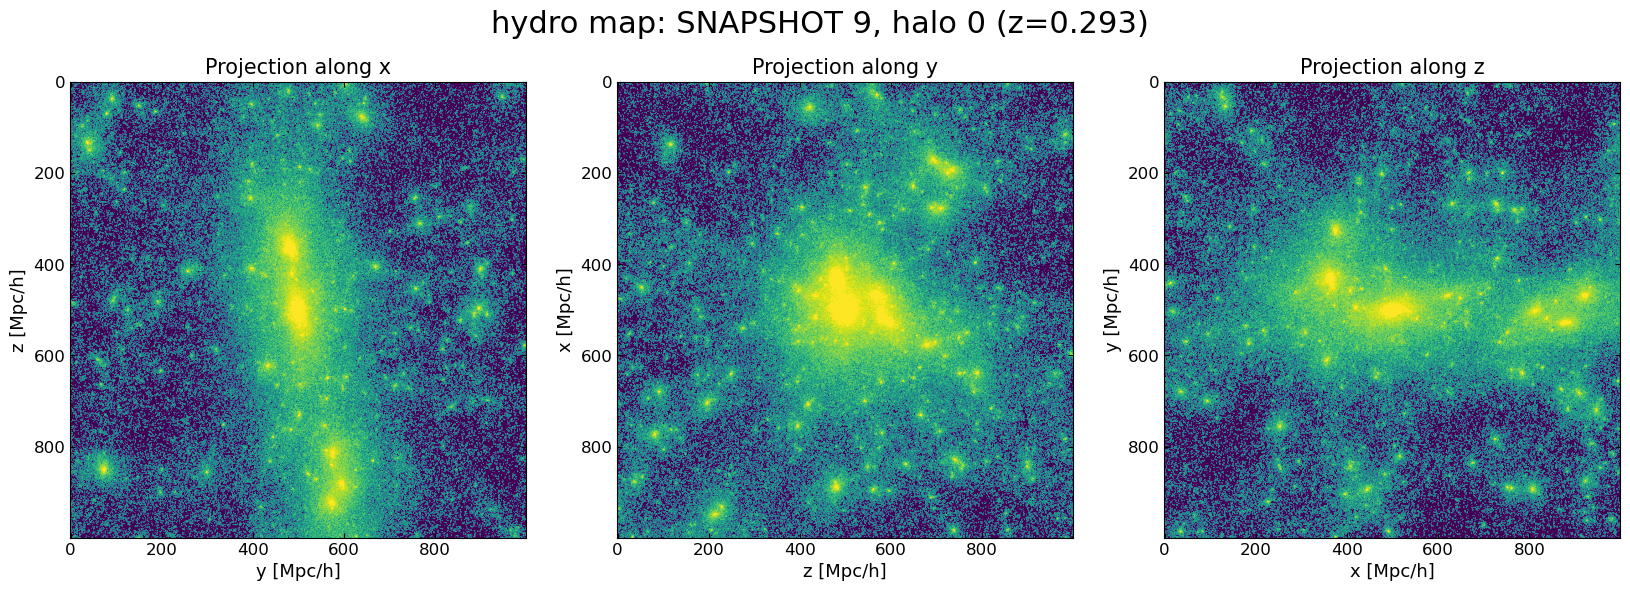

In [133]:
from matplotlib.colors import SymLogNorm, LogNorm

halo_num = 0
mass_map = file['halos/%s/hydro_Sigma' %halo_num][:]

fig,ax = plt.subplots(1,3,figsize=(20,8))

axis = ['x','y','z']
for i in range(3):
    plt.sca(ax[i])
    plt.imshow(mass_map[i,:,:], norm=SymLogNorm(linthresh=0.01, linscale=0.1,vmin=0.0001,vmax=9)) #norm=LogNorm(vmin=0.01, vmax=7))
    plt.title('Projection along %s' %axis[i], fontsize=15)
    plt.xlabel('%s [Mpc/h]' %np.roll(axis, -1)[i],fontsize=13)
    plt.ylabel('%s [Mpc/h]' %np.roll(axis, -2)[i],fontsize=13)

plt.suptitle('%s map: SNAPSHOT 9, halo %s (z=%1.3f)' %(sim_type, halo_num, redshifts[snap_num]), fontsize=22, y=0.87)

# Extract profiles

The maps obtained here can be used, for instance, to extract realistic halo profiles for weak-lensing statitics (see model_profile.py functions), etc..

(See "demo_model_profile.ipynb" for more details)

In [57]:
# profile modelling package
import clmm.model_profile as mod
from clmm import Cosmology


/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:230: RuntimeWarning: divide by zero encountered in divide
  oper_1  = - 1./(k[:, None]**2 + k[None, :]**2) * (k[:, None]**2 - k[None, :]**2)
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:230: RuntimeWarning: invalid value encountered in multiply
  oper_1  = - 1./(k[:, None]**2 + k[None, :]**2) * (k[:, None]**2 - k[None, :]**2)
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:231: RuntimeWarning: divide by zero encountered in divide
  oper_2  = - 2./(k[:, None]**2 + k[None, :]**2) * k[:, None]*k[None, :]
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:231: RuntimeWarning: invalid value encountered in multiply
  oper_2  = - 2./(k[:, None]**2 + k[None, :]**2) * k[:, None]*k[None, :]
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:273: RuntimeWarning: invalid value encountered in divide
  angle  = -np.sign(from_cent_2) * np.arccos(from_cent_1/np.sqrt(from_cent_1**2 + from_cent_2**2))
/Us

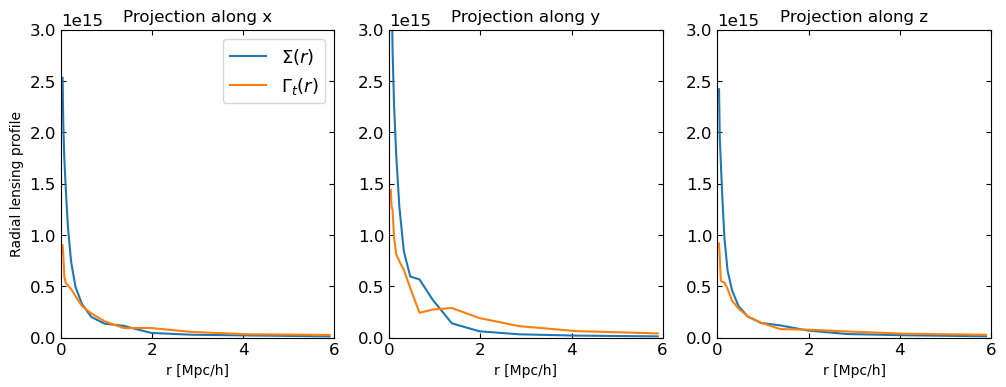

In [161]:
z_snap  = file['redshift'][()] #get the redshift of the data that is being loaded
dx      = file['resolution [kpc/h]'][()]*1.e-3
l_proj  = file['l_proj'][()]*1.e-3 # get the length scale over which the matter distribution is projected in Mpc/h

Omega_m = float(cosmo[:5])
Omega_b = float(cosmo[6:12])
sigma_8 = float(cosmo[13:18])
h       = float(cosmo[-5:])

cosmo_ccl = Cosmology(H0=h*100, Omega_dm0=Omega_m-Omega_b, Omega_b0=Omega_b, Omega_k0=0.0)
rho_M_z = Omega_m * cosmo_ccl.get_rho_c(z_snap)*(1+z_snap)**3   # background density for the halo
floor   = 2*l_proj*rho_M_z                                  # background projected density for the halo

# bins
r_min = -2.
r_max = 1.
N_r_bins = 20
r_bins = np.insert(np.logspace(r_min, r_max, N_r_bins), 0, 0) #define the radial bins

phi_min = -np.pi
phi_max = np.pi
N_phi_bins = 20
phi_bins = np.linspace(phi_min, phi_max+0.01, num=N_phi_bins+1) #define the angular bins

# maps
Sigma_map = mass_map = file['halos/%s/hydro_Sigma' %halo_num][:]

cvec1 = ['mediumblue', 'dodgerblue', 'skyblue']
cvec2 = ['brown', 'orange', 'gold']
fig,ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):

    Sigma_map_i = Sigma_map[i]/dx**2 * 1e10 - floor

    # extract shear maps
    e1_map, e2_map = mod.KaiserSquires(Sigma_map_i)
    
    # get tangential and cross maps, along with radius and angle maps
    et_map, ex_map, radius_map, angle_map = mod.get_Tangential_and_Cross(e1_map, e2_map, [0,0], dx=dx)
    
    # given the radius and angle maps, create kappa and shear radial profiles
    Sigma_radial, Gammat_radial = mod.get_Radial(radius_map,angle_map,r_bins,phi_bins,Sigma_map_i,et_map)
    
    # fig,ax = plt.subplots(1,2,figsize=(10,4))
    # plt.sca(ax[0])
    # plt.imshow(kappa_radial)
    # plt.colorbar()
    
    # plt.sca(ax[1])
    # plt.imshow(gammat_radial)
    # plt.colorbar()
    
    # get mean profiles
    Sigma_1D_radial  = Sigma_radial.mean(axis=-1)
    Gammat_1D_radial = Gammat_radial.mean(axis=-1)
    
    # plot profiles
    plt.sca(ax[i])
    r_bins_mid = 0.5 * (r_bins[1:] + r_bins[:-1])
    plt.plot(r_bins_mid,Sigma_1D_radial,label=r'$\Sigma(r)$ ')
    plt.plot(r_bins_mid,Gammat_1D_radial,label=r'$\Gamma_t(r)$')
    plt.title('Projection along %s' %axis[i], fontsize=12)
    plt.xlabel('r [Mpc/h]')
    if i==0:
        plt.ylabel('Radial lensing profile')
        plt.legend(fontsize=13)
    plt.xlim(0,6)
    plt.ylim(0,3e15)


plt.show()

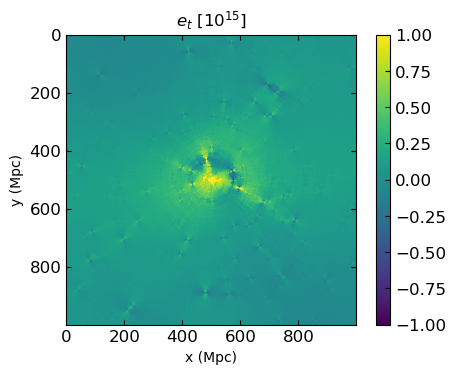

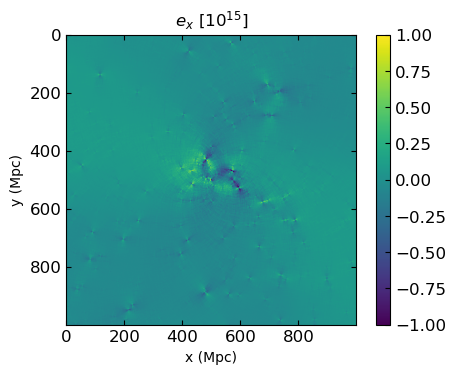

In [99]:
plt.figure(figsize=(5,5))
plt.imshow(et_map*1e-15,vmin=-1,vmax=1)
plt.xlabel('x (Mpc)')
plt.ylabel('y (Mpc)')
plt.colorbar()#.set_label(r'$e_t \ [10^{15}]$',rotation=90,fontsize=12)
plt.title(r'$e_t \ [10^{15}]$')
plt.subplots_adjust(bottom=0.3)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(ex_map*1e-15,vmin=-1,vmax=1)
plt.xlabel('x (Mpc)')
plt.ylabel('y (Mpc)')
plt.colorbar()#.set_label(r'$e_x \ [10^{15}]$',rotation=90,fontsize=12)
plt.title(r'$e_x \ [10^{15}]$')
plt.subplots_adjust(bottom=0.3)
plt.show()